## Imports

In [1]:
import numpy as np
import pylab as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm

## System

> NLSE differential equation

\begin{equation}
\partial_z A + \frac{\alpha}{2}A+\frac{i}{2}\beta_2 \partial_T^2 A = i \gamma \| A\|^2 A
\end{equation}

For now, let's suppose $\alpha=0$

\begin{equation}
\partial_z A = (\hat{D}+\hat{N})A 
\end{equation}

with $\hat{D}=-\frac{i}{2}\beta_2 \partial_T^2$ and $\hat{N}=i \gamma \| A\|^2$



The operator $\hat{D}$ will be computed in the fourier domain such that $\hat{D}(\omega)=\frac{i}{2}\omega^2\beta_2$

Finally we have at first glance :

\begin{equation}
A(z+h, T)=e^{h\hat{N}} F^{-1} \cdot e^{h\hat{D}(\omega)} \cdot F \cdot A(z,t)
\end{equation}

Where $F$ is the Fourier operator, $h$ is the propagation step (of a few meters) and $\beta_2=-D\lambda^2/2\pi c$ wich is related to the optical fiber chromatic dispersion.

> Source : doi:10.1109/ICEE.2007.4287333 

In [312]:
# Constants

c=3e8 # light celerity
l0 = 1.55e-6 # wavelength
nm = 1e-9 # nanometer
ns = 1e-9
km = 5e3 #kilometer
ps = 1e-12 #picosecond
D = 17*ps/nm/km # Dispersion
b2 = -D*l0**2/(2*np.pi*c) # group velocity dispersion (2nd order)
w0 = 2*np.pi*1e10
# Parameters

alpha=0#0.00005 # Losses
gamma=0.78e-3 # [1]/m/W Nonlinear factor https://ieeexplore.ieee.org/document/7764544

L = 5e3 # Fiber length

Nt= 10000 # Time sampling
Nl = 5000 # Length sampling

# Calculated factors and vectors

h = L/Nl # Lengthstep
dT = 0.1*ps # FWHM
T = np.linspace(-50, 50, Nt)*ps # Pulse local time vector
z = np.arange(0, Nl, 1)*h # Propagation distance vector
P0=120 # W
n = 0.03

dt = T[1]-T[0] # timestep
w =  np.fft.fftshift(np.fft.fftfreq(Nt, d=dt)) # Pulsation vector # ?? 2*np.pi*c/l0 +
Dw = 0.5*1j*w**2*b2 # Calculated dispersion operator

Noise = np.random.randn(1,Nt) # Amplitude noise vector

A =np.asarray(np.zeros((Nl, Nt), dtype=complex)) # System matrix
B =np.asarray(np.zeros((Nl, Nt), dtype=complex))
A[0,:]= n*np.sqrt(P0)*Noise + 0.5*np.sqrt(P0)*(np.exp(-T**2/(10*(dT)**2))) # Initial state
A[0, :] +=  np.sqrt(P0)*(np.exp(-(T-10*ps)**2/(2*(dT)**2)))
A[0, :] +=  np.sqrt(P0)*(np.exp(-(T+10*ps)**2/(2*(dT)**2)))
#A[0,:]= n*np.sqrt(P0)*Noise + np.sqrt(P0)*np.sin(w0*T) # Initial state
B[0,:]=np.fft.fftshift(np.fft.fft(A[0,:]))



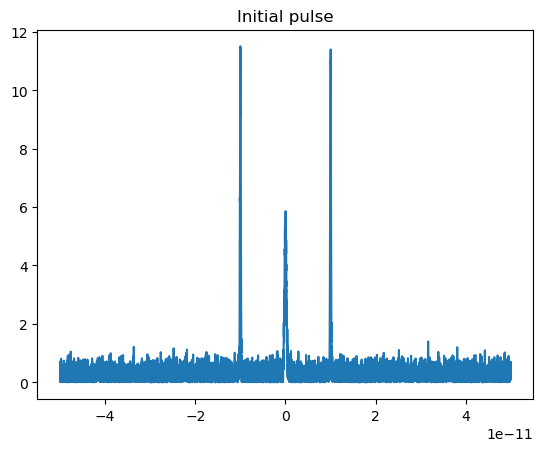

In [313]:
plt.plot(T,np.abs(A[0,:]))
plt.title("Initial pulse")
plt.show()


In [314]:
for i in tqdm(range(1,Nl)):
    
    N = 1j*gamma*np.abs(A[i-1,:])**2-0.5*alpha
    Ai = np.exp(0.5*h*N)*A[i-1,:] # half Nonlinearity 1
    Ai = np.fft.fftshift(np.fft.fft(Ai)) # Fourier domain
    Ai = np.exp(h*Dw)*Ai # Dispersion in Fourier domain
    Ai = np.fft.ifft(np.fft.ifftshift(Ai)) # Temporal domain
    Ai = np.exp(0.5*h*N)*Ai # half Nonlinearity 2
    A[i,:] = Ai
    B[i,:] = np.fft.fftshift(np.fft.fft(Ai))

100%|█████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:30<00:00, 164.10it/s]


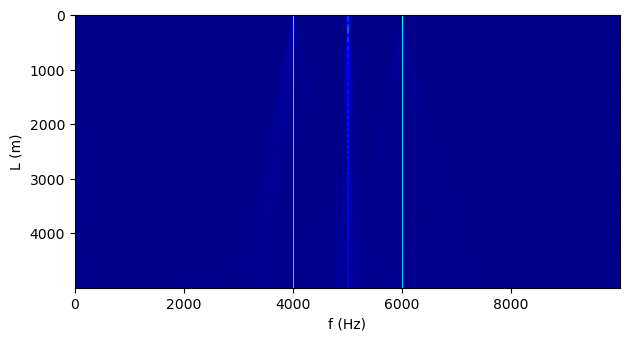

In [315]:
f = w/(2*np.pi)
extent = [f[0], f[-1], z[-1], z[0]]
plt.imshow(np.abs(A), aspect=1, cmap='jet')
plt.xlabel(r"f (Hz)")
plt.ylabel(r"L (m)")

plt.tight_layout()
plt.show()

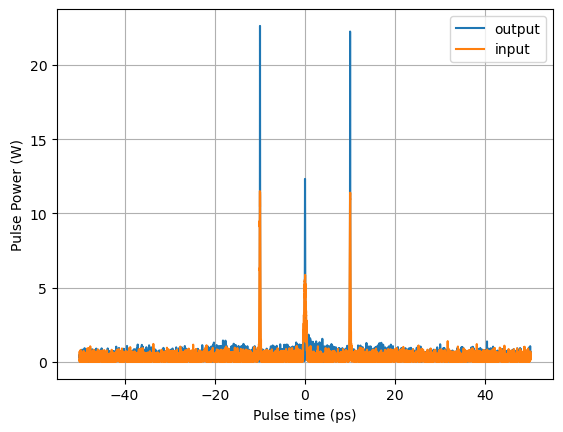

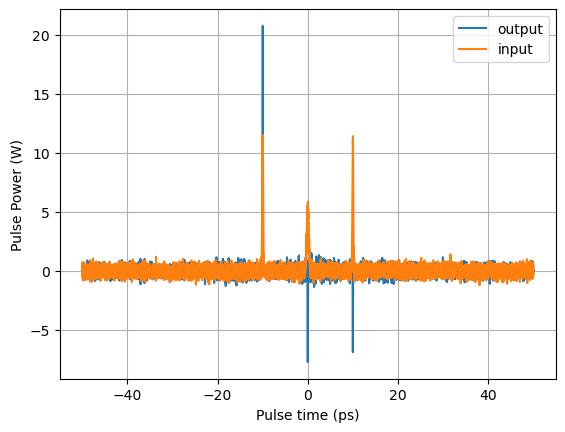

In [316]:
plt.plot(T/ps,np.abs(A[-1,:]), label='output')
plt.plot(T/ps,np.abs(A[0,:]), label='input')


plt.grid()
plt.legend()
plt.xlabel("Pulse time (ps)")
plt.ylabel("Pulse Power (W)")
plt.show()

plt.figure()
plt.plot(T/ps,np.real(A[-1,:]), label='output')
plt.plot(T/ps,np.real(A[0,:]), label='input')


plt.grid()
plt.legend()
plt.xlabel("Pulse time (ps)")
plt.ylabel("Pulse Power (W)")

plt.show()


In [279]:
w[0]

-4999499999998.172

In [302]:
Dw

array([-0.-0.05415821j, -0.-0.05413655j, -0.-0.0541149j , ...,
       -0.-0.05409324j, -0.-0.0541149j , -0.-0.05413655j])

In [301]:
N

array([0.+4.25759166e-08j, 0.+1.08248965e-08j, 0.+7.47240172e-08j, ...,
       0.+1.06654191e-07j, 0.+4.60674140e-09j, 0.+9.80428558e-08j])

In [25]:
h

50.0

In [26]:
c/l0

193548387096774.2

In [82]:
z[-1]

4997.5